In [1]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.dataviz import plot_raster
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import _pipeline

In [2]:
path="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/in_out_b1_b2/2025_01_03_12_05_07/pfc/population.h5"

In [3]:
popu = PopulationData.from_python_hdf5(path)

In [258]:
start_sample = 0
end_sample = 300

In [259]:
st_target = 0
end_target = 150
cerotr, percentile=True,True
st_bl = -200
end_bl = 0

In [6]:
allres=[]
for i,neu in enumerate(popu.population[125:300]):
    res = _pipeline.get_space_neutral_roc(
        neu,
        start_sample,
        end_sample,
        st_target,
        end_target,
        st_bl,
        end_bl,
        cerotr=cerotr,
        percentile=percentile,
    )
    allres.append(res)

KeyboardInterrupt: 

In [ ]:
i

27

In [303]:
path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/neutral_space_idx/2025_01_08_15_39_07/pfc'
df = pd.read_csv(f'{path}/neutral_space_idx.csv')
df['neutral_idx'] = df['neutral_in']-df['neutral_out']
df['spatial_idx'] = df['space_in']-df['space_out']
df

,Unnamed: 0,nid,neutral_in,neutral_latin,neutral_out,neutral_latout,space_in,space_latin,space_out,space_latout,neutral_idx,spatial_idx
0,0,2022-12-01_10-23-18_Riesling_pfc_e1_r1_mua1,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1,1,2022-12-01_10-23-18_Riesling_pfc_e1_r1_mua2,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,2,2022-12-01_10-23-18_Riesling_pfc_e1_r1_good2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2022-11-22_10-59-03_Riesling_pfc_e1_r1_mua14,0.000000,NaN,0.000000,NaN,0.453125,120.0,0.000000,NaN,0.000000,0.453125
4,4,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua24,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2117,2117,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua21,0.232388,174.0,0.068537,174.0,0.000000,NaN,0.000000,NaN,0.163850,0.000000
2118,2118,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good11,0.305471,181.0,0.241968,190.0,0.000000,NaN,0.000000,NaN,0.063503,0.000000
2119,2119,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua22,0.000000,NaN,-0.151441,238.0,0.000000,NaN,0.333333,146.0,0.151441,-0.333333
2120,2120,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good12,0.000000,NaN,0.275992,288.0,0.000000,NaN,0.000000,NaN,-0.275992,0.000000


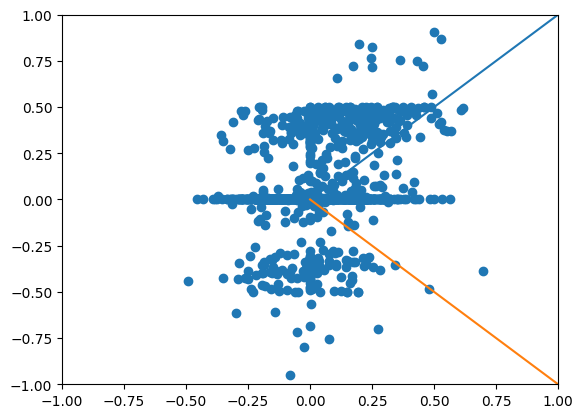

In [304]:
plt.scatter(df['neutral_idx'],df['spatial_idx'])
# df_zero = df[np.logical_and(abs(df['neutral_idx'])<0.2,abs(df['spatial_idx'])<0.2)]
# plt.scatter(df_zero['neutral_idx'],df_zero['spatial_idx'])
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot([0,1],[0,1])
plt.plot([0,1],[0,-1])

In [296]:
# # Test basis
# gg=np.array([[0,0.2,0.3,0.4,0.5,0.6,0.7,0.9,0.8,0.9,0.6],[0,0.2,0.3,0.4,0.5,0.6,0.7,0.9,0.2,0.5,0.9]])
# plt.scatter(gg[0],gg[1])
# plt.plot([0,1],[0,1])
# plt.plot([0,-1],[0,1])
# points = gg
# basis = np.array([[1,1],[-1,1]])
# rot = np.dot(points.T,basis).T
# plt.scatter(rot[0],rot[1])

In [305]:
df_nonan = df[np.logical_and(~np.isnan(df['neutral_idx']),~np.isnan(df['spatial_idx']))]
len(df_nonan)

1347

In [298]:
points = np.array([df_nonan['neutral_idx'],df_nonan['spatial_idx']])
basis = np.array([[1,1],[-1,1]])
rot = np.dot(points.T,basis).T
std_rot_3 = np.std(rot[0])/3

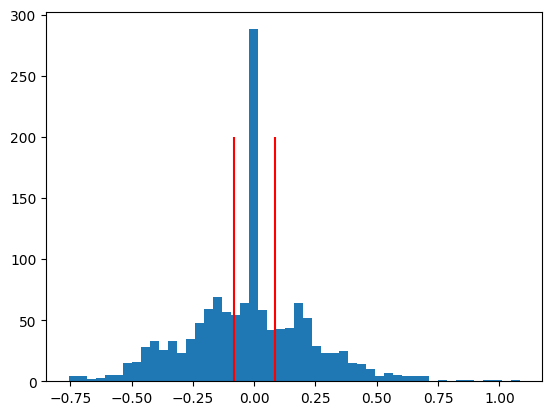

In [299]:
plt.hist(rot[0],bins=50)
plt.vlines([std_rot_3,-std_rot_3],0,200,color='r')
idx_out = np.where(np.abs(rot[0])>std_rot_3)
idx_in = np.where(np.abs(rot[0])<std_rot_3)

(-1.0, 1.0)

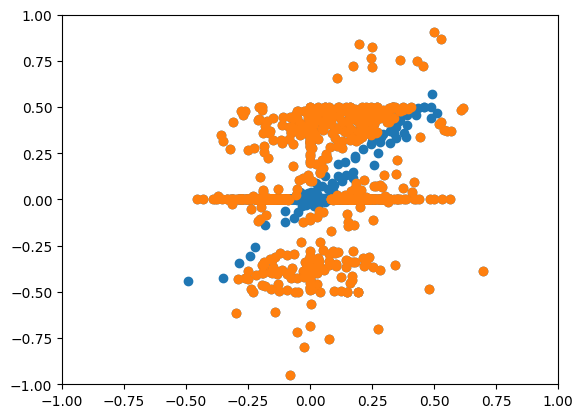

In [300]:
plt.scatter(df_nonan['neutral_idx'],df_nonan['spatial_idx'])
plt.scatter(df_nonan['neutral_idx'].values[idx_out],df_nonan['spatial_idx'].values[idx_out])
# df_zero = df[np.logical_and(abs(df['neutral_idx'])<0.2,abs(df['spatial_idx'])<0.2)]
# plt.scatter(df_zero['neutral_idx'],df_zero['spatial_idx'])
plt.xlim([-1,1])
plt.ylim([-1,1])

In [301]:
pd.DataFrame(df_nonan.values[idx_in])

,0,1,2,3,4,5,6,7,8,9,10,11
0,4,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua24,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
1,5,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good13,0.220378,261.0,0.184165,270.0,0.0,NaN,0.0,NaN,0.036212,0.0
2,6,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua25,-0.26893,173.0,-0.235289,180.0,0.0,NaN,0.0,NaN,-0.033641,0.0
3,12,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua29,-0.223361,260.0,-0.284124,251.0,-0.33432,83.0,-0.46,92.0,0.060762,0.12568
4,14,2022-11-22_10-59-03_Riesling_pfc_e1_r1_mua15,-0.196429,298.0,-0.136738,299.0,0.0,NaN,0.0,NaN,-0.059691,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
478,2109,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good8,-0.190523,194.0,-0.125718,196.0,0.0,NaN,0.0,NaN,-0.064805,0.0
479,2113,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good9,0.337478,146.0,0.32338,155.0,0.488166,88.0,0.45,97.0,0.014098,0.038166
480,2115,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good10,-0.2285,275.0,-0.311764,283.0,0.0,NaN,0.0,NaN,0.083264,0.0
481,2118,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good11,0.305471,181.0,0.241968,190.0,0.0,NaN,0.0,NaN,0.063503,0.0


In [302]:
path1 = f'{path}/in_1st/b1'
path2 = f'{path}/in_1st/b2'
if not os.path.exists(path1):
    os.makedirs(path1)
if not os.path.exists(path2):
    os.makedirs(path2)

for nid in df_nonan['nid'].values[idx_in]:#[np.arange(0,892,11)]:
    if nid[:19]=='2023-03-09_10-35-09':continue
    path_n=f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/{nid}_neu.h5'
    neu_n = NeuronData.from_python_hdf5(path_n)
    sp, conv = plot_raster.prepare_data_plotb1(neu_n,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
    fig1=plot_raster.plot_sp_b1(neu_n,sp, conv)
    fig1.savefig(path1+'/'+nid+'.jpg',format='jpg')
    sp_pos, conv_pos, max_n_tr, conv_max = plot_raster.prepare_data_plotb2(neu_n)
    fig2 = plot_raster.plot_sp_b2(neu_n,sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1,bl_st=100, bl_end=200, tg_st=250, tg_end=350)
    fig2.savefig(path2+'/'+nid+'.jpg',format='jpg')
    plt.close('all')

KeyboardInterrupt: 

In [306]:
df_nonan[df_nonan['spatial_idx']==0.5]

,Unnamed: 0,nid,neutral_in,neutral_latin,neutral_out,neutral_latout,space_in,space_latin,space_out,space_latout,neutral_idx,spatial_idx
59,59,2023-03-10_10-30-26_Riesling_pfc_e1_r1_good3,0.376509,152.0,0.343325,159.0,0.5,101.0,0.0,NaN,0.033184,0.5
63,63,2023-03-10_10-30-26_Riesling_pfc_e1_r1_mua26,0.209594,200.0,0.000000,NaN,0.5,92.0,0.0,NaN,0.209594,0.5
64,64,2023-03-10_10-30-26_Riesling_pfc_e1_r1_good5,0.317720,128.0,0.091182,135.0,0.5,91.0,0.0,NaN,0.226538,0.5
149,149,2023-03-16_10-20-01_Riesling_pfc_e1_r1_mua4,0.233100,143.0,0.114677,148.0,0.5,68.0,0.0,NaN,0.118423,0.5
385,385,2023-03-21_10-40-02_Riesling_pfc_e1_r1_good16,-0.195417,246.0,0.000000,NaN,0.5,148.0,0.0,NaN,-0.195417,0.5
476,476,2023-03-30_10-36-53_Riesling_pfc_e1_r1_good9,0.407554,138.0,0.000000,NaN,0.5,72.0,0.0,NaN,0.407554,0.5
508,508,2023-01-20_11-00-24_Riesling_pfc_e1_r1_mua5,0.000000,NaN,-0.333768,171.0,0.0,NaN,-0.5,147.0,0.333768,0.5
598,598,2022-11-30_10-42-03_Riesling_pfc_e1_r1_mua4,0.362288,147.0,0.302627,156.0,0.5,71.0,0.0,NaN,0.059662,0.5
751,751,2023-10-18_10-57-56_Riesling_pfc_e1_r1_good6,0.331897,92.0,0.000000,NaN,0.5,84.0,0.0,NaN,0.331897,0.5
1169,1169,2022-12-02_11-01-23_Riesling_pfc_e1_r1_mua16,0.334248,107.0,0.000000,NaN,0.5,92.0,0.0,NaN,0.334248,0.5


In [283]:
nid = '2023-03-10_10-30-26_Riesling_pfc_e1_r1_good4' #df_nonan['nid'].values[12]#  listdf[6]

In [284]:
df[df['nid']==nid]

,Unnamed: 0,nid,neutral_in,neutral_latin,neutral_out,neutral_latout,space_in,space_latin,space_out,space_latout,neutral_idx,spatial_idx
61,61,2023-03-10_10-30-26_Riesling_pfc_e1_r1_good4,-0.176008,206.0,-0.206127,215.0,0.0,NaN,0.0,NaN,0.03012,0.0


In [285]:
path=f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/{nid}_neu.h5'
neu_n = NeuronData.from_python_hdf5(path)

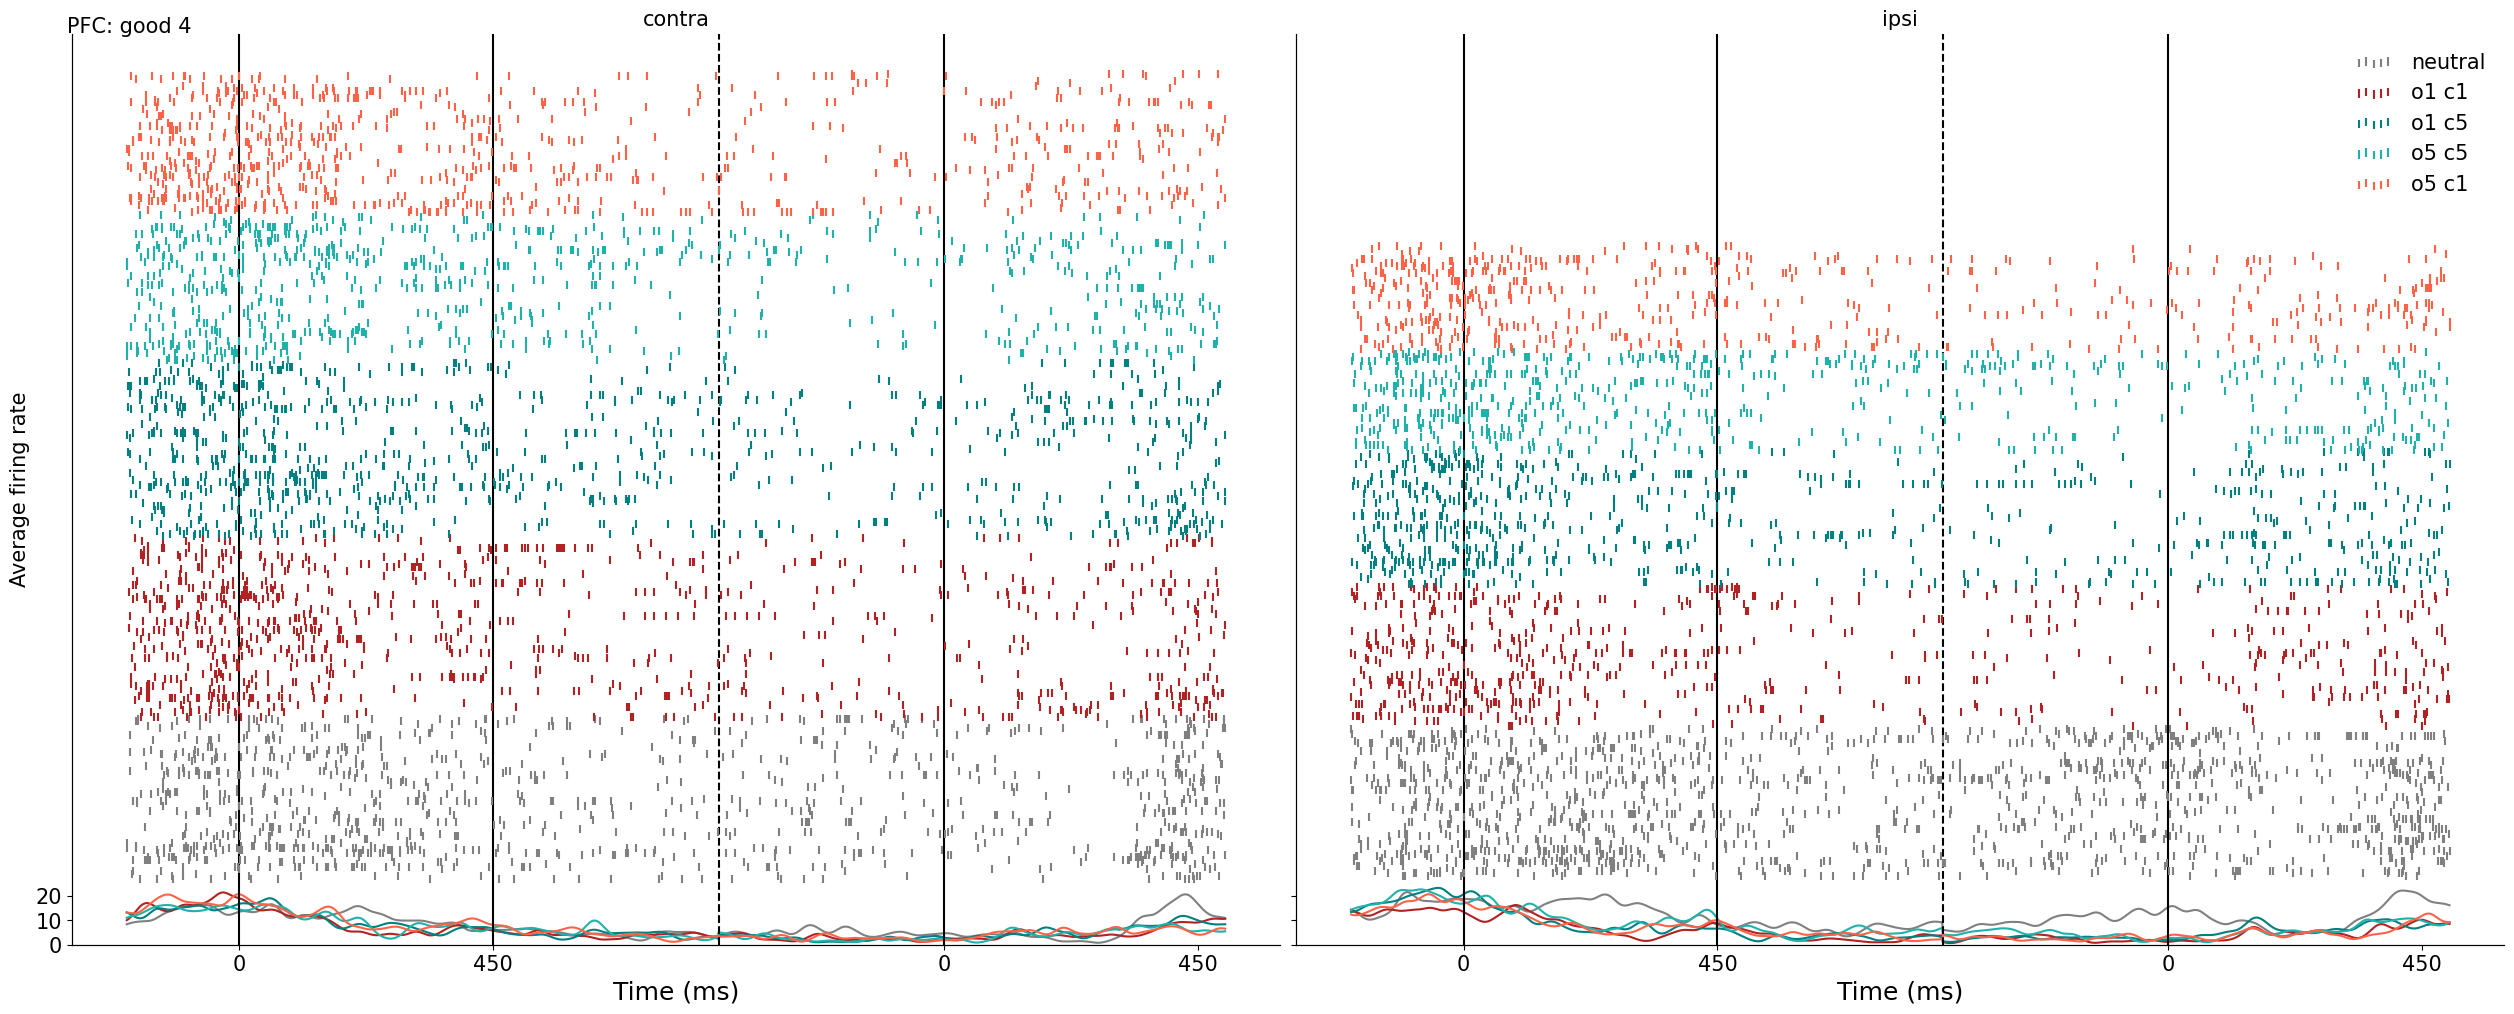

In [286]:
sp, conv = plot_raster.prepare_data_plotb1(neu_n,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
fig=plot_raster.plot_sp_b1(neu_n,sp, conv)

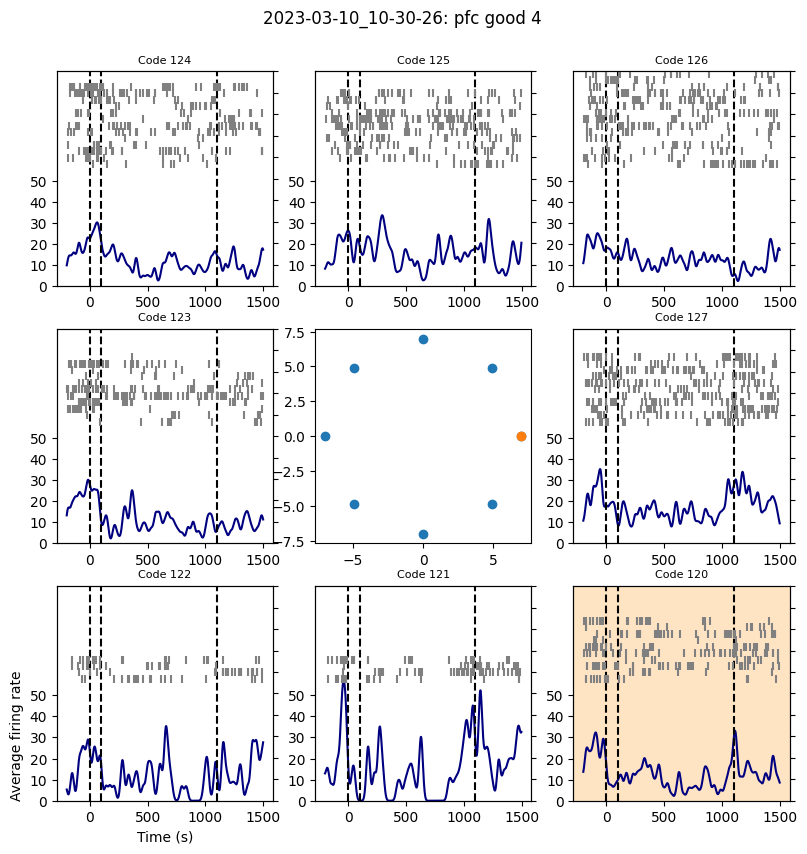

In [287]:
sp_pos, conv_pos, max_n_tr, conv_max = plot_raster.prepare_data_plotb2(neu_n)
fig = plot_raster.plot_sp_b2(neu_n,sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1,bl_st=100, bl_end=200, tg_st=250, tg_end=350)

In [288]:
nid='2023-03-09_10-35-09_Riesling_pfc_e1_r1_good13'

In [289]:
for i in range(2000):
    if popu.population[i].get_neuron_id()==nid:
        print(i)
    

5


In [290]:
neu = popu.population[5]

In [293]:
res = _pipeline.get_space_neutral_roc(
    neu,
    start_sample,
    end_sample,
    st_target,
    end_target,
    st_bl,
    end_bl,
    cerotr=cerotr,
    percentile=percentile,
)

In [292]:
res

{'nid': '2023-03-09_10-35-09_Riesling_pfc_e1_r1_good13',
 'neutral_in': np.float64(0.22037770332013396),
 'neutral_latin': np.int64(261),
 'neutral_out': np.float64(0.18416539634146334),
 'neutral_latout': np.int64(270),
 'space_in': 0,
 'space_latin': nan,
 'space_out': 0,
 'space_latout': nan}